In [1]:
import numpy as np
from numpy import cos, sin, conjugate, sqrt
from scipy.special import factorial
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
src = cv.imread(cv.samples.findFile('lena.png'))
gray_img = cv.cvtColor(src, cv.COLOR_BGR2GRAY)

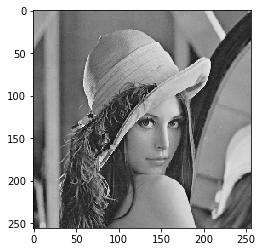

In [3]:
plt.imshow(gray_img,cmap='gray')

In [4]:
def zernike_poly(Y, X, n, l):
    def polar(r, theta):
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        return 1. * x + 1.j * y
    
    Vxy = np.zeros(Y.size, dtype=complex)
    Vnm = np.zeros(Y.size, dtype=complex)
    for m in range(int(n - l) // 2 + 1):
        Vnm += (-1.) ** m * factorial(n - m) / \
               (factorial(m) * factorial((n - 2 * m + l) // 2) * factorial((n - 2 * m - l) // 2)) * \
               (sqrt(np.square(X) + np.square(Y)) ** (n - 2 * m) * polar(1.0, l * np.arctan2(Y, X)))
    Vxy += Vnm

    return Vxy

In [5]:
def zernike_moments(img, radius, D, cof):
    idx = np.ones(img.shape)
    cofy, cofx = cof
    cofy = float(cofy)
    cofx = float(cofx)
    radius = float(radius)
    Y, X = np.where(idx > 0)
    P = img[Y, X]
    Y_normalised = Y / radius - cofy / radius
    X_normalised = X / radius - cofx / radius

    # pick the circle
    k = (np.sqrt(np.square(X_normalised) + np.square(Y_normalised)) <= 1.)
    frac_center = np.array(P[k], np.double)
    Y_normalised = Y_normalised[k]
    X_normalised = X_normalised[k]

    quantity_of_pixels = float(frac_center.size)
    
    moments = []
    S = []
    for n in range(D + 1):
        for m in range(n + 1):
            if (n - m) % 2 == 0:
                Vxy = zernike_poly(Y_normalised, X_normalised, float(n), float(m))
                Anm = np.sum(frac_center * conjugate(Vxy)) * (n + 1) / quantity_of_pixels
                moments += [Anm]
                if n < 44 and m != 44:
                    S += [Anm]
                
    return (np.array(moments),np.array(S))

In [6]:
def zernike_reconstruct(img, radius, D, cof, moments):
    idx = np.ones(img.shape)

    cofy, cofx = cof
    cofy = float(cofy)
    cofx = float(cofx)
    radius = float(radius)

    Y, X = np.where(idx > 0)
    P = img[Y, X]
    Y_normalised = Y / radius - cofy / radius
    X_normalised = X / radius - cofx / radius

    # pick the circle
    k = (np.sqrt(np.square(X_normalised) + np.square(Y_normalised)) <= 1.)
    frac_center = np.array(P[k], np.double)
    Y_normalised = Y_normalised[k]
    X_normalised = X_normalised[k]

    quantity_of_pixels = float(frac_center.size)

    reconstr = np.zeros(img.size, dtype=complex)
    acc = np.zeros(Y_normalised.size, dtype=complex)
    moment_index = 0
    for n in range(D + 1):
        for m in range(n + 1):
            if (n - m) % 2 == 0:
                Vxy = zernike_poly(Y_normalised, X_normalised, float(n), float(m))
                Anm = moments[moment_index]
                acc += Anm * Vxy
                moment_index+=1
                
                
    reconstr[k] = acc
    return reconstr

In [7]:
img = gray_img
degree = 32
rows, cols = img.shape
radius = min(cols // 2, rows // 2)
moments,S = zernike_moments(img, radius, degree, (rows / 2., cols / 2.))

In [8]:
reconst = zernike_reconstruct(img, radius, degree, (rows / 2., cols / 2.),moments).reshape(img.shape)

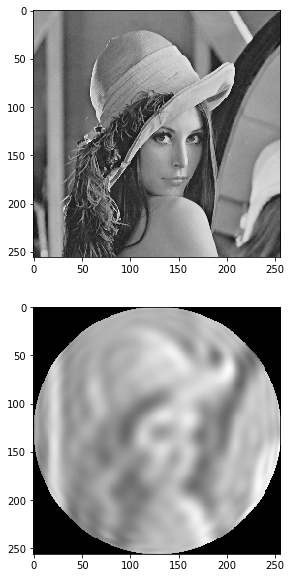

In [9]:
fig,ax = plt.subplots(2,figsize=(10,10))    
ax[0].imshow(img, cmap='gray')
ax[1].imshow(reconst.real,cmap='gray')
plt.show()

Widać że rekonstrukcja z wykorzystaniem wielomianów zernike nie daje zbyt dobrych efektów, natomiast kształt obrazka ciągle może być rozpoznany

In [10]:
bits = 8
b = np.random.randint(0,2,bits)

In [11]:
moments_mask = np.zeros(moments.shape)
np.random.choice(range(len(moments)), bits, replace=False)
moments_mask[np.random.choice(range(len(moments)), bits, replace=False)] = 1
K = moments_mask > 0

In [12]:
oryginal_moments = np.copy(moments)

In [13]:
delta = 0.7

In [14]:
d0 = np.random.rand(bits) * delta

In [15]:
def d(b,i):
    return d0[i] if b == 0 else d0[i] + delta/2

In [16]:
def qim(x,b,i):
    return int((x - d(b,i))/delta)*delta + d(b,i)

In [17]:
index = 0
b_i = 0
for m in moments:
    if K[index]:
        moments[index]=qim(moments[index],b[b_i],b_i)
        b_i += 1
    index +=1

/home/pituuuss/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [18]:
water_mark = zernike_reconstruct(img, radius, degree, (rows / 2., cols / 2.),moments - oryginal_moments).reshape(img.shape)
encoded = water_mark.real + img

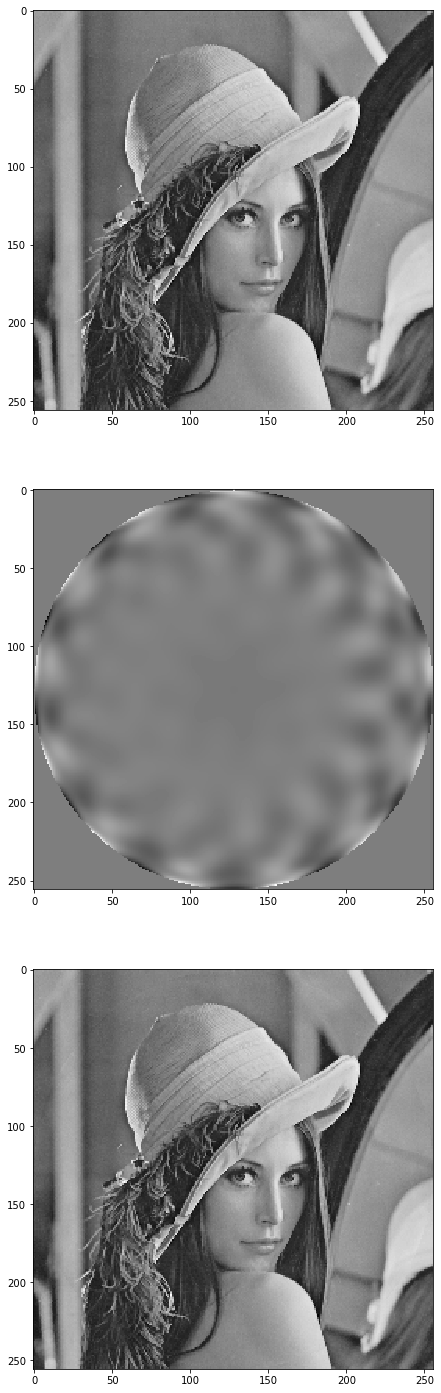

In [19]:
fig,ax = plt.subplots(3,figsize=(25,25))    
ax[0].imshow(img, cmap='gray')
ax[1].imshow(water_mark.real, cmap='gray')
ax[2].imshow(encoded.real,cmap='gray')
plt.show()

Można zauważyć że na zmodyfikowanym obrazie brak jest jakich wyraźnie widocznych artefaktów

In [20]:
rows, cols = encoded.shape
radius = min(cols // 2, rows // 2)
mm,s = zernike_moments(encoded.real,radius,degree, (rows / 2., cols / 2.))

In [21]:
mm0=mm[K]
mm1=mm[K]

In [22]:
for i in range(len(mm0)):
        mm0[i]=qim(mm0[i],0,i)
        mm1[i]=qim(mm1[i],1,i)

/home/pituuuss/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [23]:
mm0

array([-5.97608439+0.j, -6.83746884+0.j,  8.06219025+0.j, -4.32550224+0.j,
       -5.22580533+0.j, -3.71399552+0.j, -1.57224358+0.j,  0.91877597+0.j])

In [24]:
mm1

array([-6.32608439+0.j, -6.48746884+0.j,  8.41219025+0.j, -3.97550224+0.j,
       -4.87580533+0.j, -4.06399552+0.j, -1.92224358+0.j,  0.56877597+0.j])

In [25]:
mm[K]

array([-6.32785037+0.j        , -6.95103639-2.7557788j ,
        8.70446964-1.15555055j, -4.57437663+1.29587618j,
       -5.22676973+0.34420604j, -4.17818154-0.17681291j,
       -2.0668715 -0.0327411j ,  1.11892175+0.50856768j])

In [26]:
def dist(a,b):
    return np.square(a.real-b.real)

In [27]:
res = np.argmin((dist(mm[K],mm0),dist(mm[K],mm1)),axis=0)
res

array([1, 0, 1, 0, 0, 1, 1, 0])

In [28]:
b

array([1, 0, 1, 0, 1, 1, 1, 0])

In [29]:
np.all(res == b)

False

Wiadomość duało się odczytać

In [30]:
encoded = cv.resize(encoded,(int(encoded.shape[0]*.7),int(encoded.shape[1]*.7)))

In [31]:
rows, cols = encoded.shape
radius = min(cols // 2, rows // 2)
mm,s = zernike_moments(encoded.real,radius,degree, (rows / 2., cols / 2.))

In [32]:
mm0=mm[K]
mm1=mm[K]

In [33]:
for i in range(len(mm0)):
        mm0[i]=qim(mm0[i],0,i)
        mm1[i]=qim(mm1[i],1,i)

/home/pituuuss/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [34]:
res = np.argmin((dist(mm[K],mm0),dist(mm[K],mm1)),axis=0)
res

array([1, 0, 1, 0, 0, 0, 1, 0])

In [35]:
b

array([1, 0, 1, 0, 1, 1, 1, 0])

In [36]:
np.all(res == b)

False

Po worowadzeniu drobnej zmiany jaką jest zmiana rozmiarów obrazna zakodowana wiadomość staje się nie czytelna

In [37]:
img = gray_img
degree = 32
rows, cols = img.shape
radius = min(cols // 2, rows // 2)
moments,S = zernike_moments(img, radius, degree, (rows / 2., cols / 2.))

In [38]:
bits = 8
b = np.random.randint(0,2,bits)

In [39]:
moments_mask = np.zeros(moments.shape)
np.random.choice(range(len(moments)), bits, replace=False)
moments_mask[np.random.choice(range(len(moments)), bits, replace=False)] = 1
K = moments_mask > 0

In [40]:
oryginal_moments = np.copy(moments)

In [41]:
delta = 50

In [42]:
d0 = np.random.rand(bits) * delta

In [43]:
def d(b,i):
    return d0[i] if b == 0 else d0[i] + delta/2

In [44]:
def qim(x,b,i):
    return int((x - d(b,i))/delta)*delta + d(b,i)

In [45]:
index = 0
b_i = 0
for m in moments:
    if K[index]:
        moments[index]=qim(moments[index],b[b_i],b_i)
        b_i += 1
    index +=1

/home/pituuuss/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [46]:
water_mark = zernike_reconstruct(img, radius, degree, (rows / 2., cols / 2.),moments - oryginal_moments).reshape(img.shape)
encoded = water_mark.real + img

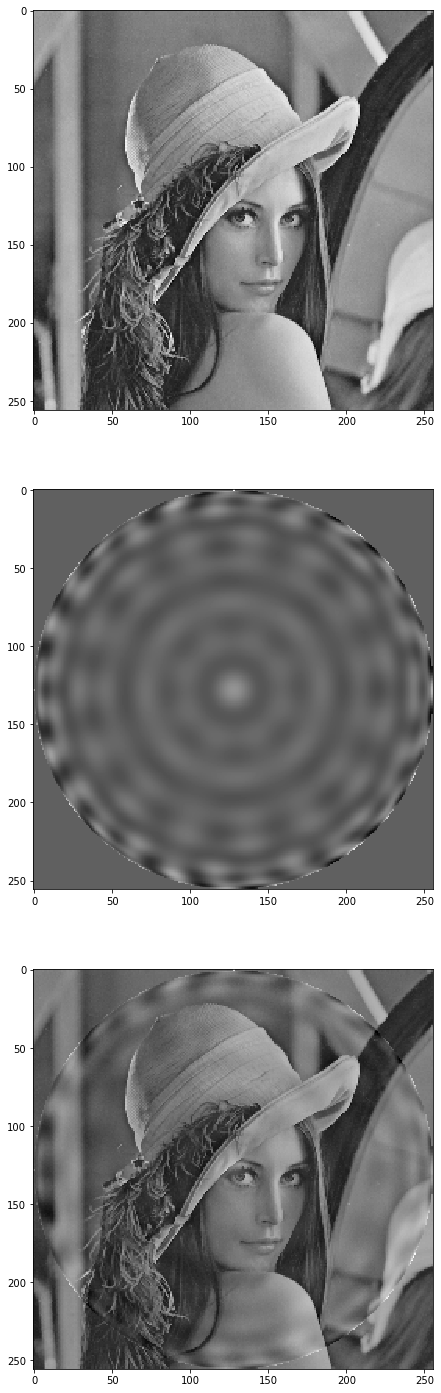

In [47]:
fig,ax = plt.subplots(3,figsize=(25,25))    
ax[0].imshow(img, cmap='gray')
ax[1].imshow(water_mark.real, cmap='gray')
ax[2].imshow(encoded.real,cmap='gray')
plt.show()

Dla dużej delty artefakty są wyraźnie widoczne